In [2]:
import warnings
warnings.filterwarnings("ignore")

!pip install imblearn

In [3]:
##libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import warnings
import scipy
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report





In [4]:
#Preparation and cleaning of the data
df = pd.read_csv('telco.csv', sep=',')#reading dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.columns = df.columns.str.replace(' ', '')  #remove empty characters from the columns

In [7]:
print(df.shape)

(7043, 21)


In [8]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
print(df.duplicated().value_counts())  #get duplicated rows

False    7043
dtype: int64


In [10]:
#Data Quality Report for categorical features
categorical_columns= df.select_dtypes(exclude=["number"]).columns
formatter = "{0:.2f}"
listModeName=[]
list_mode=[]
print(f"{'Feature' : <16}{'Count' : ^10}{'Card' : ^10}{'Mode':^16}{'Mode Freq':^15}{'Mode(%)':^15}{'2nd Mode':^15}{'2nd Mode Freq':^15}{'2nd Mode(%)':^15}")
for i in range(len(categorical_columns)):
    listModeName.extend(df[categorical_columns[i]].value_counts().index.tolist())  
    list_mode.extend(df[categorical_columns[i]].value_counts())  
    print(f"{categorical_columns[i]: <16}{df[categorical_columns[i]].count(): ^10}{df[categorical_columns[i]].nunique(): ^10}{df[categorical_columns[i]].mode().values[0]: ^16}{df[categorical_columns[i]].value_counts().max(): ^15}{formatter.format((df[categorical_columns[i]].value_counts().max()/df[categorical_columns[i]].count())*100): ^15}{listModeName[1]: ^15}{list_mode[1]: ^15}{formatter.format((list_mode[1]/df[categorical_columns[i]].count())*100): ^15}")
    list_mode.clear() 
    listModeName.clear()

Feature           Count      Card         Mode         Mode Freq       Mode(%)       2nd Mode     2nd Mode Freq   2nd Mode(%)  
customerID         7043      7043      0002-ORFBO          1            0.01        3791-LGQCY          1            0.01      
gender             7043       2           Male           3555           50.48         Female          3488           49.52     
Partner            7043       2            No            3641           51.70           Yes           3402           48.30     
Dependents         7043       2            No            4933           70.04           Yes           2110           29.96     
PhoneService       7043       2           Yes            6361           90.32           No             682           9.68      
MultipleLines      7043       3            No            3390           48.13           Yes           2971           42.18     
InternetService    7043       3       Fiber optic        3096           43.96           DSL           24

In [11]:
TotalCharges_median = df[df['TotalCharges'] != ' ']['TotalCharges'].apply(pd.to_numeric).median() #get the median without the empty strings
df["TotalCharges"].replace([' '], TotalCharges_median,inplace = True) #fil empty values with median
df['TotalCharges'] = df['TotalCharges'].apply(pd.to_numeric) #make the column type numeric 
print(TotalCharges_median, '\n')

1397.475 



In [12]:
#Data Quality Report for numeric features
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
dqr_num = df[numeric_cols].describe()
cardinality = df.apply(pd.Series.nunique)
dqr_num.loc['cardinality'] = cardinality[dqr_num.columns]
dqr_num = dqr_num.T

print(dqr_num)

                 count         mean          std    min      25%       50%  \
tenure          7043.0    32.371149    24.559481   0.00    9.000    29.000   
MonthlyCharges  7043.0    64.761692    30.090047  18.25   35.500    70.350   
TotalCharges    7043.0  2281.916928  2265.270398  18.80  402.225  1397.475   

                    75%      max  cardinality  
tenure            55.00    72.00         73.0  
MonthlyCharges    89.85   118.75       1585.0  
TotalCharges    3786.60  8684.80       6531.0  


In [13]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [14]:
df['TotalCharges'].sort_values(ascending=False)

4610    8684.80
4586    8672.45
6768    8670.10
5347    8594.40
2187    8564.75
         ...   
583       19.00
4939      18.90
1151      18.85
6489      18.85
1654      18.80
Name: TotalCharges, Length: 7043, dtype: float64

In [15]:
df.drop(columns = ["customerID"],inplace = True)  #remove the customerID column

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [17]:
#encoding the features that have 2 values
binary_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'PhoneService', 'Churn'] 

for i in binary_cols: 
    if(i == 'gender'):
        df[i].replace({'Female': 0, 'Male': 1}, inplace=True) 
    else:
        df[i].replace({'No': 0, 'Yes': 1}, inplace=True) 

In [18]:
#encoding the features that have more than 2 values
encode_cols = ["MultipleLines", "InternetService", "OnlineSecurity", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod", "OnlineBackup"]
ohe = OneHotEncoder(sparse = False)

for i in encode_cols:
    df = pd.concat((df , pd.DataFrame(ohe.fit_transform(df[i].to_frame()),columns = str(i+"_") + np.sort(df[i].unique()))),axis = 1)
    df.drop(columns = [i],inplace = True)
    

In [19]:
print(df.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Maile

In [20]:
scaler = MinMaxScaler(feature_range=(0, 1), copy=True)  #max min normalization [0,1]
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df), index=df.index, columns=df.columns)
#df

In [21]:
df['tenure'].value_counts()

0.013889    613
1.000000    362
0.027778    238
0.041667    200
0.055556    176
           ... 
0.388889     57
0.541667     56
0.611111     51
0.500000     50
0.000000     11
Name: tenure, Length: 73, dtype: int64

In [22]:
df.columns = df.columns.str.replace(' ', '')  #remove empty characters on the columns which occured after the encoding
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,Contract_Month-to-month,Contract_Oneyear,Contract_Twoyear,PaymentMethod_Banktransfer(automatic),PaymentMethod_Creditcard(automatic),PaymentMethod_Electroniccheck,PaymentMethod_Mailedcheck,OnlineBackup_No,OnlineBackup_Nointernetservice,OnlineBackup_Yes
0,0.0,0.0,1.0,0.0,0.013889,0.0,1.0,0.115423,0.001275,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.472222,1.0,0.0,0.385075,0.215867,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.027778,1.0,1.0,0.354229,0.010310,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.625000,0.0,0.0,0.239303,0.210241,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.027778,1.0,1.0,0.521891,0.015330,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,0.0,1.0,1.0,0.333333,1.0,1.0,0.662189,0.227521,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7039,0.0,0.0,1.0,1.0,1.000000,1.0,1.0,0.845274,0.847461,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7040,0.0,0.0,1.0,1.0,0.152778,0.0,1.0,0.112935,0.037809,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7041,1.0,1.0,1.0,0.0,0.055556,1.0,1.0,0.558706,0.033210,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [23]:
df.info()  #check the types and names of the columns
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = df.corr().abs()

# Getting the upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))
print(list(to_drop))
df = df.drop(columns = to_drop)
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 41 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   gender                                 7043 non-null   float64
 1   SeniorCitizen                          7043 non-null   float64
 2   Partner                                7043 non-null   float64
 3   Dependents                             7043 non-null   float64
 4   tenure                                 7043 non-null   float64
 5   PhoneService                           7043 non-null   float64
 6   PaperlessBilling                       7043 non-null   float64
 7   MonthlyCharges                         7043 non-null   float64
 8   TotalCharges                           7043 non-null   float64
 9   Churn                                  7043 non-null   float64
 10  MultipleLines_No                       7043 non-null   float64
 11  Mult

(7043, 34)

<AxesSubplot:>

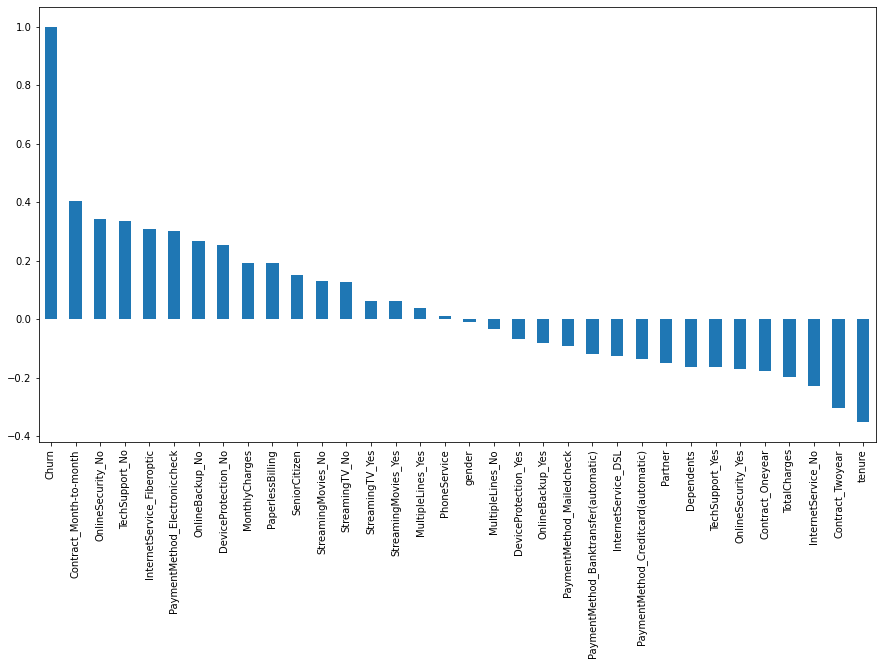

In [24]:
plt.figure(figsize=(15,8))
df.corr()['Churn'].sort_values(ascending = False).plot(kind='bar') #Correlation of "Churn" with other features:

In [25]:
# For Test and Train - Normal, %90, %10
y = df.Churn.to_frame()
X = df.drop(columns = ["Churn"])
X_train , X_test , y_train , y_test = train_test_split(X,y, test_size = 0.25, random_state = 10)

LogisticRegression() : 0.8001135718341851


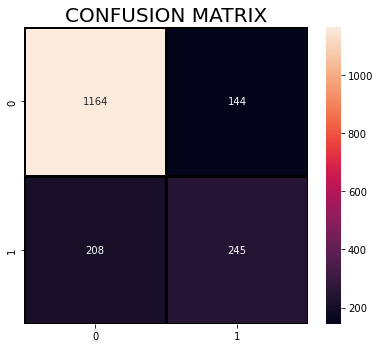

              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      1308
         1.0       0.63      0.54      0.58       453

    accuracy                           0.80      1761
   macro avg       0.74      0.72      0.73      1761
weighted avg       0.79      0.80      0.79      1761

R2 Score:  -0.04615509245195115
Mean Absolute Error:  0.19988642816581487
Mean Squared Error 0.19988642816581487


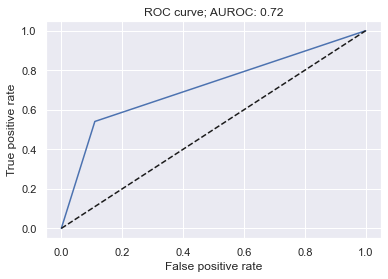

GaussianNB() : 0.7194775695627484


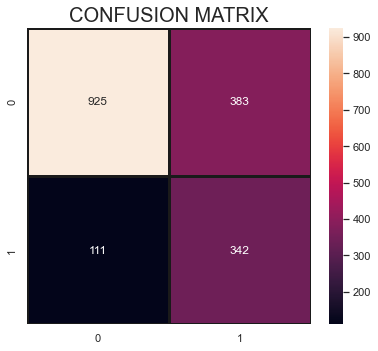

              precision    recall  f1-score   support

         0.0       0.89      0.71      0.79      1308
         1.0       0.47      0.75      0.58       453

    accuracy                           0.72      1761
   macro avg       0.68      0.73      0.68      1761
weighted avg       0.78      0.72      0.74      1761

R2 Score:  -0.4681835672479089
Mean Absolute Error:  0.28052243043725156
Mean Squared Error 0.28052243043725156


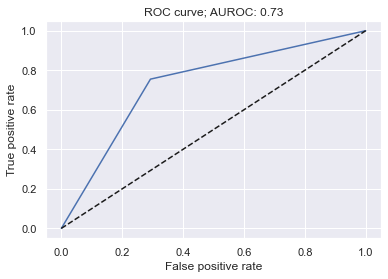

SGDClassifier() : 0.7887563884156729


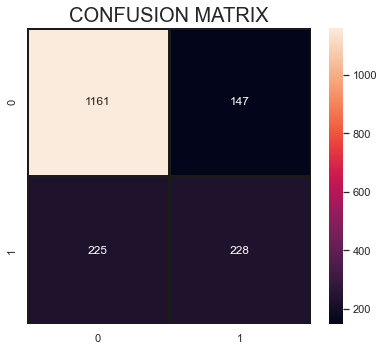

              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86      1308
         1.0       0.61      0.50      0.55       453

    accuracy                           0.79      1761
   macro avg       0.72      0.70      0.71      1761
weighted avg       0.78      0.79      0.78      1761

R2 Score:  -0.10559572270490292
Mean Absolute Error:  0.21124361158432708
Mean Squared Error 0.21124361158432708


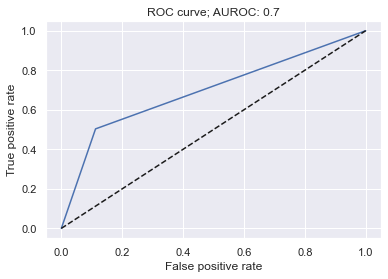

KNeighborsClassifier() : 0.7444633730834753


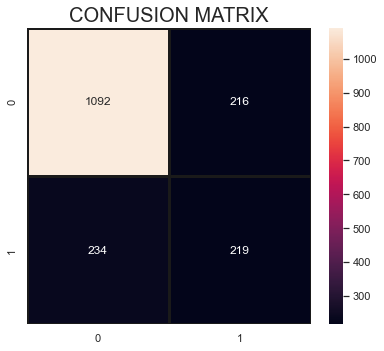

              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83      1308
         1.0       0.50      0.48      0.49       453

    accuracy                           0.74      1761
   macro avg       0.66      0.66      0.66      1761
weighted avg       0.74      0.74      0.74      1761

R2 Score:  -0.3374141806914148
Mean Absolute Error:  0.2555366269165247
Mean Squared Error 0.2555366269165247


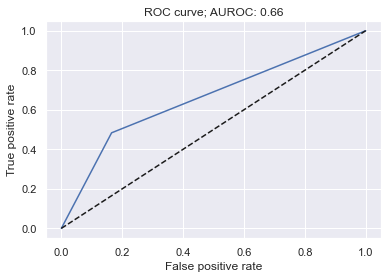

DecisionTreeClassifier() : 0.7262918796138558


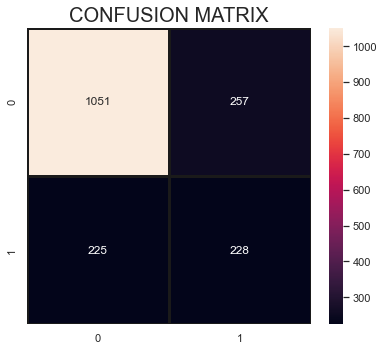

              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81      1308
         1.0       0.47      0.50      0.49       453

    accuracy                           0.73      1761
   macro avg       0.65      0.65      0.65      1761
weighted avg       0.73      0.73      0.73      1761

R2 Score:  -0.43251918909613774
Mean Absolute Error:  0.2737081203861442
Mean Squared Error 0.2737081203861442


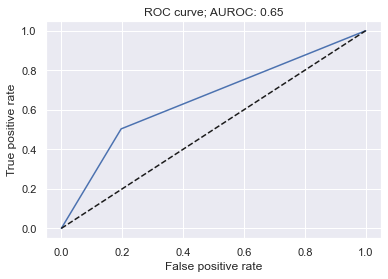

RandomForestClassifier() : 0.7842135150482681


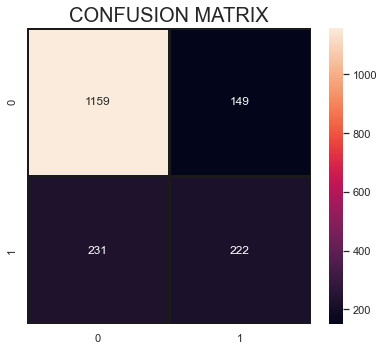

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1308
         1.0       0.60      0.49      0.54       453

    accuracy                           0.78      1761
   macro avg       0.72      0.69      0.70      1761
weighted avg       0.77      0.78      0.78      1761

R2 Score:  -0.12937197480608376
Mean Absolute Error:  0.21578648495173197
Mean Squared Error 0.21578648495173197


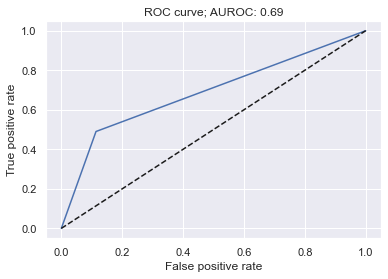

SVC() : 0.7825099375354913


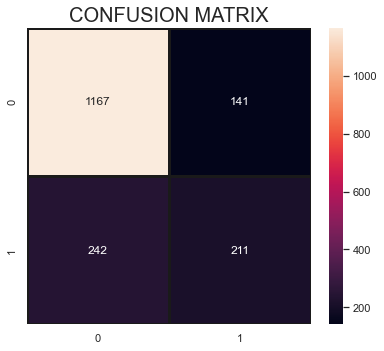

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      1308
         1.0       0.60      0.47      0.52       453

    accuracy                           0.78      1761
   macro avg       0.71      0.68      0.69      1761
weighted avg       0.77      0.78      0.77      1761

R2 Score:  -0.1382880693440265
Mean Absolute Error:  0.2174900624645088
Mean Squared Error 0.2174900624645088


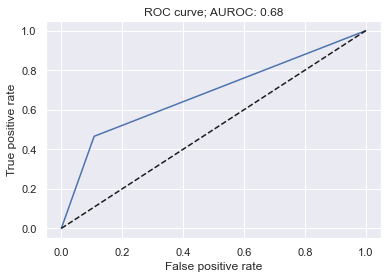

AdaBoostClassifier() : 0.8057921635434412


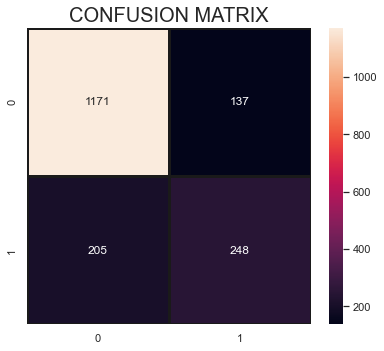

              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87      1308
         1.0       0.64      0.55      0.59       453

    accuracy                           0.81      1761
   macro avg       0.75      0.72      0.73      1761
weighted avg       0.80      0.81      0.80      1761

R2 Score:  -0.01643477732547538
Mean Absolute Error:  0.19420783645655879
Mean Squared Error 0.19420783645655879


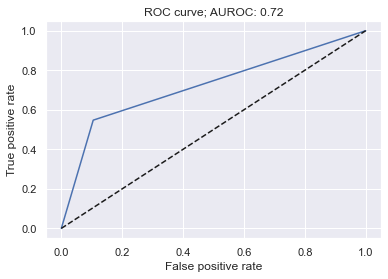

[23:45:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) : 0.7950028392958546


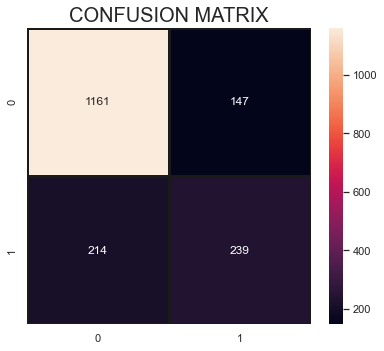

              precision    recall  f1-score   support

         0.0       0.84      0.89      0.87      1308
         1.0       0.62      0.53      0.57       453

    accuracy                           0.80      1761
   macro avg       0.73      0.71      0.72      1761
weighted avg       0.79      0.80      0.79      1761

R2 Score:  -0.07290337606577957
Mean Absolute Error:  0.20499716070414536
Mean Squared Error 0.20499716070414536


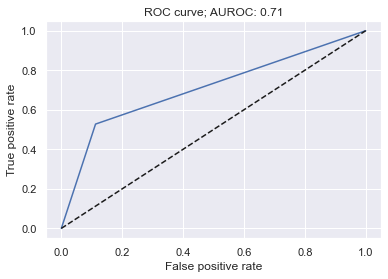

MLPClassifier() : 0.7847813742191937


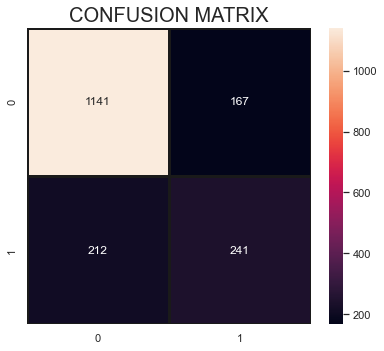

              precision    recall  f1-score   support

         0.0       0.84      0.87      0.86      1308
         1.0       0.59      0.53      0.56       453

    accuracy                           0.78      1761
   macro avg       0.72      0.70      0.71      1761
weighted avg       0.78      0.78      0.78      1761

R2 Score:  -0.12639994329343618
Mean Absolute Error:  0.21521862578080636
Mean Squared Error 0.21521862578080636


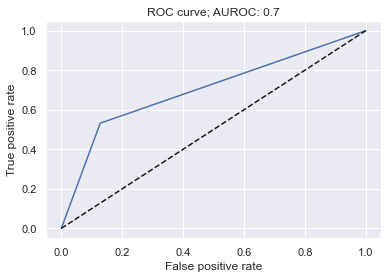

In [26]:
# Models
# Train and Test
models = [LogisticRegression(),
          GaussianNB(),
          SGDClassifier(),
          KNeighborsClassifier(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          SVC(),
          AdaBoostClassifier(), 
          XGBClassifier(),
          MLPClassifier()
         ]

for i, model in enumerate(models):
    model.fit(X_train, y_train)
    print(models[i], ':', model.score(X_test, y_test))
    y_pred = model.predict(X_test)

#Confusion Matrix

    plt.figure(figsize=(14,12))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True,fmt = 'd',linecolor="k",linewidths=3)

    plt.title("CONFUSION MATRIX",fontsize=20)
    plt.show()

# Evaulation Metrics 
    
    report = classification_report(y_test, y_pred)
    print(report)
    
    from sklearn.metrics import r2_score
    r2score = r2_score(y_test, y_pred)
    print('R2 Score: ', r2score)
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(y_test, y_pred)
    print('Mean Absolute Error: ', mae)
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test, y_pred)
    print('Mean Squared Error' ,mse)
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    sns.set()

    plt.plot(fpr, tpr)

    plt.plot(fpr, fpr, linestyle = '--', color = 'k')

    plt.xlabel('False positive rate')

    plt.ylabel('True positive rate')

    AUROC = np.round(roc_auc_score(y_test, y_pred), 2)

    plt.title(f'ROC curve; AUROC: {AUROC}');

    plt.show()

In [27]:
# SMOTE - Oversampling
# Oversampled Test and Train, %90, %10
sm = SMOTE()
X_sm , y_sm = sm.fit_resample(X, y)
y_sm.Churn.value_counts()

0.0    5174
1.0    5174
Name: Churn, dtype: int64

LogisticRegression() : 0.7723231542327019


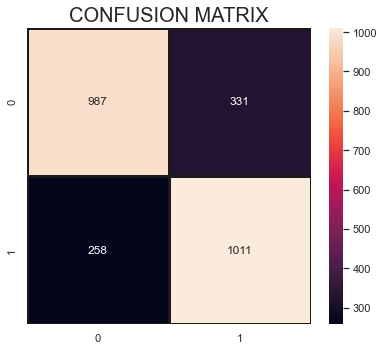

              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77      1318
         1.0       0.75      0.80      0.77      1269

    accuracy                           0.77      2587
   macro avg       0.77      0.77      0.77      2587
weighted avg       0.77      0.77      0.77      2587

R2 Score:  0.08896577783995852
Mean Absolute Error:  0.22767684576729802
Mean Squared Error 0.22767684576729802


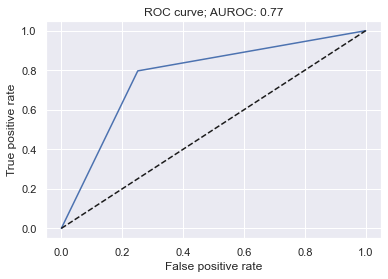

GaussianNB() : 0.7626594511016621


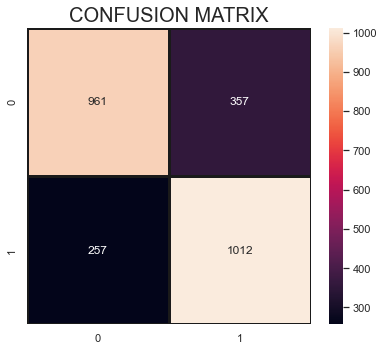

              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76      1318
         1.0       0.74      0.80      0.77      1269

    accuracy                           0.76      2587
   macro avg       0.76      0.76      0.76      2587
weighted avg       0.76      0.76      0.76      2587

R2 Score:  0.050297092688853184
Mean Absolute Error:  0.23734054889833783
Mean Squared Error 0.23734054889833783


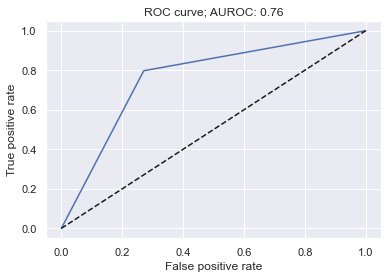

SGDClassifier() : 0.7638190954773869


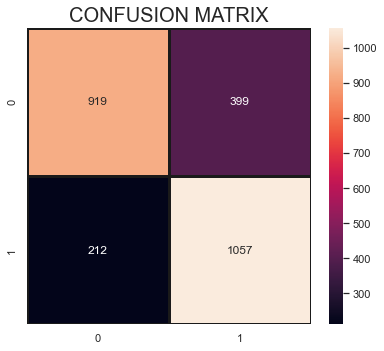

              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75      1318
         1.0       0.73      0.83      0.78      1269

    accuracy                           0.76      2587
   macro avg       0.77      0.77      0.76      2587
weighted avg       0.77      0.76      0.76      2587

R2 Score:  0.054937334906985824
Mean Absolute Error:  0.23618090452261306
Mean Squared Error 0.23618090452261306


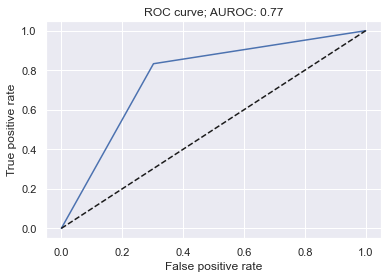

KNeighborsClassifier() : 0.7792810204870506


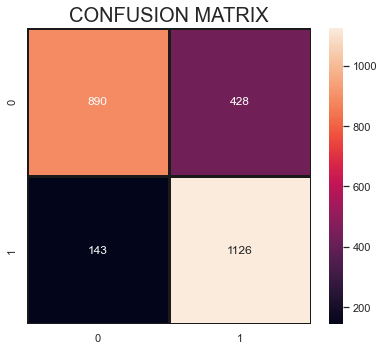

              precision    recall  f1-score   support

         0.0       0.86      0.68      0.76      1318
         1.0       0.72      0.89      0.80      1269

    accuracy                           0.78      2587
   macro avg       0.79      0.78      0.78      2587
weighted avg       0.79      0.78      0.78      2587

R2 Score:  0.11680723114875435
Mean Absolute Error:  0.22071897951294936
Mean Squared Error 0.22071897951294936


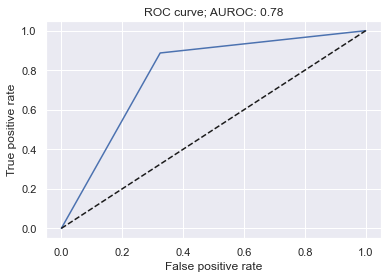

DecisionTreeClassifier() : 0.7877850792423656


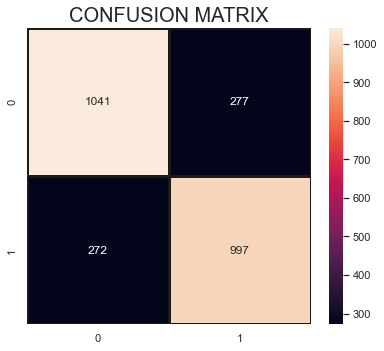

              precision    recall  f1-score   support

         0.0       0.79      0.79      0.79      1318
         1.0       0.78      0.79      0.78      1269

    accuracy                           0.79      2587
   macro avg       0.79      0.79      0.79      2587
weighted avg       0.79      0.79      0.79      2587

R2 Score:  0.15083567408172704
Mean Absolute Error:  0.21221492075763432
Mean Squared Error 0.21221492075763432


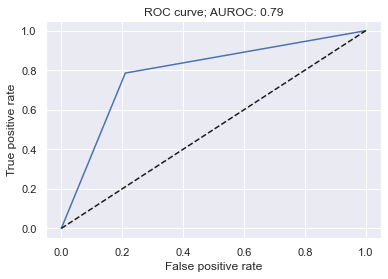

RandomForestClassifier() : 0.8465403942790878


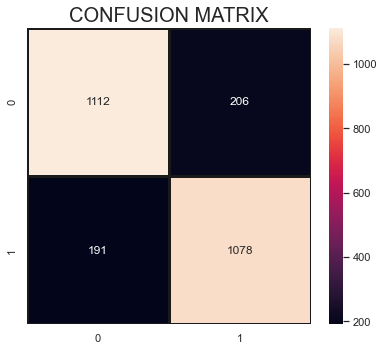

              precision    recall  f1-score   support

         0.0       0.85      0.84      0.85      1318
         1.0       0.84      0.85      0.84      1269

    accuracy                           0.85      2587
   macro avg       0.85      0.85      0.85      2587
weighted avg       0.85      0.85      0.85      2587

R2 Score:  0.38594127980044746
Mean Absolute Error:  0.15345960572091225
Mean Squared Error 0.15345960572091225


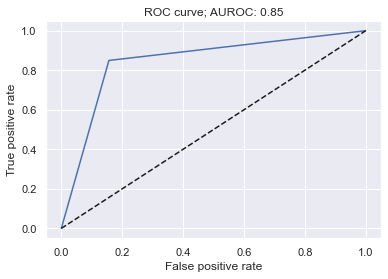

SVC() : 0.8129107073830691


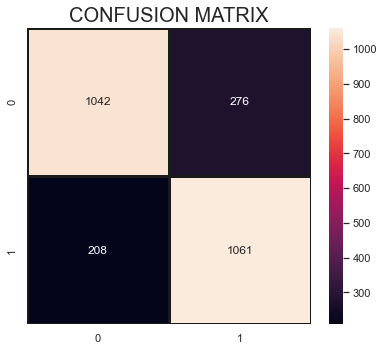

              precision    recall  f1-score   support

         0.0       0.83      0.79      0.81      1318
         1.0       0.79      0.84      0.81      1269

    accuracy                           0.81      2587
   macro avg       0.81      0.81      0.81      2587
weighted avg       0.81      0.81      0.81      2587

R2 Score:  0.2513742554746009
Mean Absolute Error:  0.1870892926169308
Mean Squared Error 0.1870892926169308


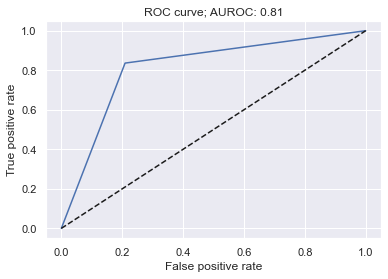

AdaBoostClassifier() : 0.8179358330112099


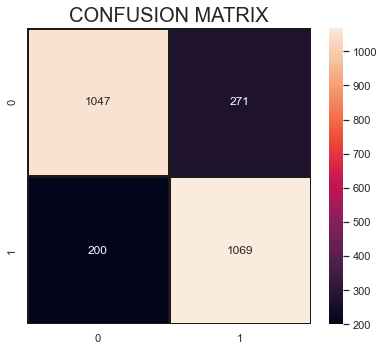

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.82      1318
         1.0       0.80      0.84      0.82      1269

    accuracy                           0.82      2587
   macro avg       0.82      0.82      0.82      2587
weighted avg       0.82      0.82      0.82      2587

R2 Score:  0.2714819717531757
Mean Absolute Error:  0.1820641669887901
Mean Squared Error 0.1820641669887901


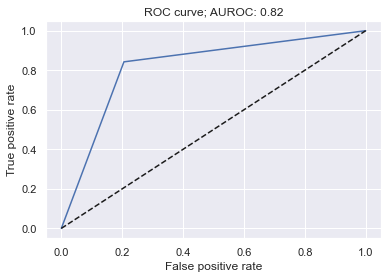

[23:45:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None) : 0.8488596830305373


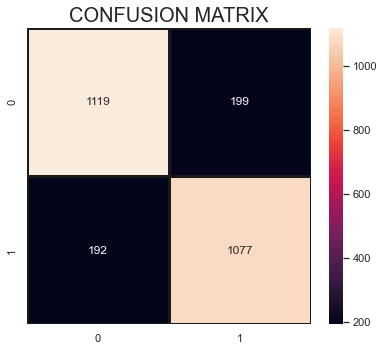

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85      1318
         1.0       0.84      0.85      0.85      1269

    accuracy                           0.85      2587
   macro avg       0.85      0.85      0.85      2587
weighted avg       0.85      0.85      0.85      2587

R2 Score:  0.39522176423671274
Mean Absolute Error:  0.1511403169694627
Mean Squared Error 0.1511403169694627


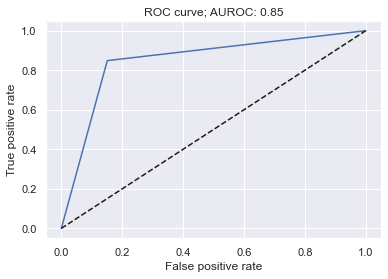

MLPClassifier() : 0.8063393892539621


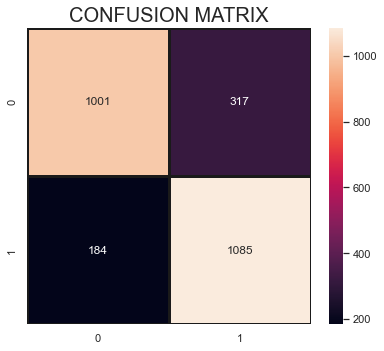

              precision    recall  f1-score   support

         0.0       0.84      0.76      0.80      1318
         1.0       0.77      0.86      0.81      1269

    accuracy                           0.81      2587
   macro avg       0.81      0.81      0.81      2587
weighted avg       0.81      0.81      0.81      2587

R2 Score:  0.22507954957184928
Mean Absolute Error:  0.19366061074603788
Mean Squared Error 0.19366061074603788


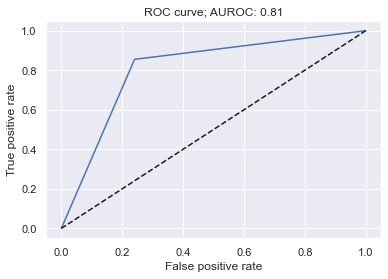

In [28]:
#Test and train oversampled
!pip install sklearn
X_train_sm , X_test_sm , y_train_sm , y_test_sm = train_test_split(X_sm, y_sm, test_size = 0.25, random_state = 10)
for i, model in enumerate(models):
    model.fit(X_train_sm, y_train_sm)
    print(models[i], ':', model.score(X_test_sm, y_test_sm))
    y_pred_sm = model.predict(X_test_sm)
    plt.figure(figsize=(14,12))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(y_test_sm, y_pred_sm),
            annot=True,fmt = 'd',linecolor="k",linewidths=3)

    plt.title("CONFUSION MATRIX",fontsize=20)
    plt.show()
 

    report = classification_report(y_test_sm, y_pred_sm)
    print(report)
    
    from sklearn.metrics import r2_score
    r2score = r2_score(y_test_sm, y_pred_sm)
    print('R2 Score: ', r2score)
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(y_test_sm, y_pred_sm)
    print('Mean Absolute Error: ', mae)
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test_sm, y_pred_sm)
    print('Mean Squared Error' ,mse)
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, thresholds = roc_curve(y_test_sm, y_pred_sm)
    sns.set()

    plt.plot(fpr, tpr)

    plt.plot(fpr, fpr, linestyle = '--', color = 'k')

    plt.xlabel('False positive rate')

    plt.ylabel('True positive rate')

    AUROC = np.round(roc_auc_score(y_test_sm, y_pred_sm), 2)

    plt.title(f'ROC curve; AUROC: {AUROC}');

    plt.show()




In [29]:
# Oversampled, Smoted, Cross Validation

X_train_sm , X_test_sm , y_train_sm , y_test_sm = train_test_split(X_sm, y_sm, test_size = 0.25, random_state = 10)
for i, model in enumerate(models):
    model.fit(X_train_sm, y_train_sm)
    print(models[i], ':', model.score(X_test_sm, y_test_sm))
    y_pred_sm = model.predict(X_test_sm)

LogisticRegression() : 0.7723231542327019
GaussianNB() : 0.7626594511016621
SGDClassifier() : 0.766524932354078
KNeighborsClassifier() : 0.7792810204870506
DecisionTreeClassifier() : 0.7916505604947816
RandomForestClassifier() : 0.8480865867800541
SVC() : 0.8129107073830691
AdaBoostClassifier() : 0.8179358330112099
[23:45:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monoton

LogisticRegression()  Avg accuracy : 0.7573476672366588


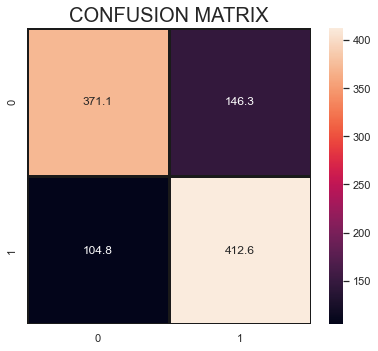

GaussianNB()  Avg accuracy : 0.7630577747876546


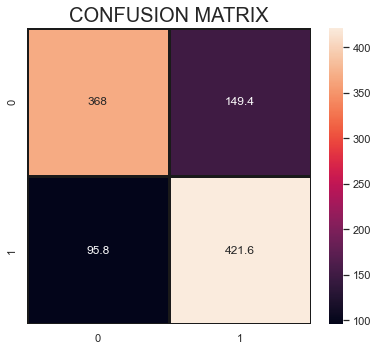

SGDClassifier()  Avg accuracy : 0.7496177314308674


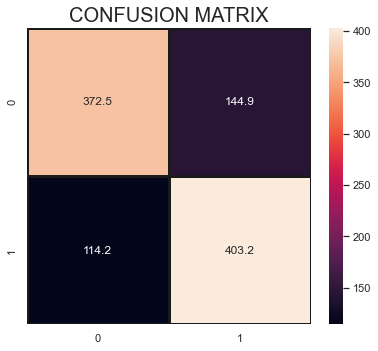

KNeighborsClassifier()  Avg accuracy : 0.7829787234042553


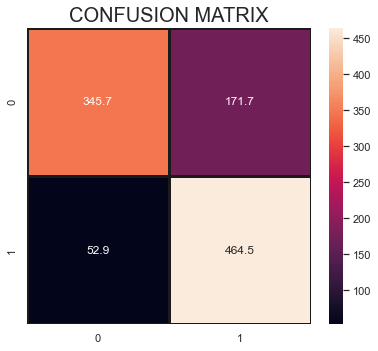

DecisionTreeClassifier()  Avg accuracy : 0.7830634747100982


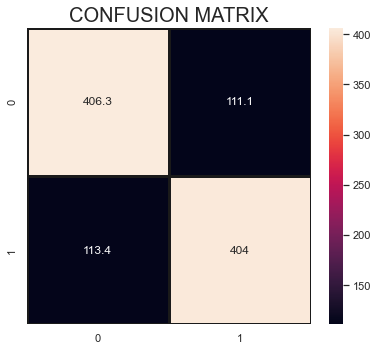

RandomForestClassifier()  Avg accuracy : 0.8511017669759576


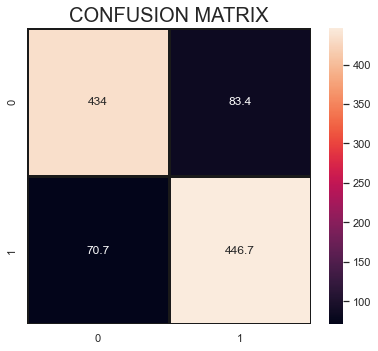

SVC()  Avg accuracy : 0.8064491352002914


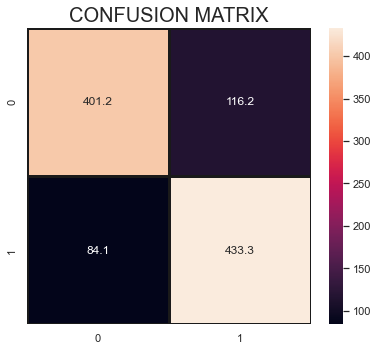

AdaBoostClassifier()  Avg accuracy : 0.8096402507965875


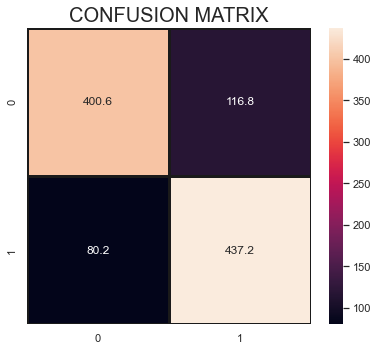

[23:47:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:47:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

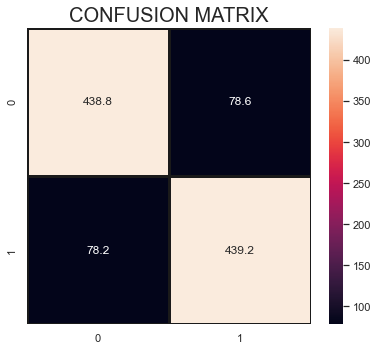

MLPClassifier()  Avg accuracy : 0.8103163924162999


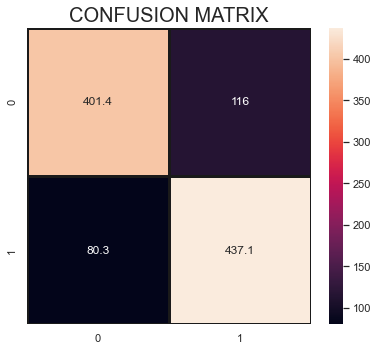

In [30]:

 
#Implementing cross validation
k = 10
kf = KFold(n_splits=k, random_state=None)



for i, model in enumerate(models):


    sum_conf_matrixes = np.zeros((2, 2))
    
    divided_by = 0
    zerozero, onezero, zeroone, oneone = 0, 0, 0, 0
    
    
    acc_score = []
    for train_index , test_index in kf.split(X_sm):
        X_train , X_test = X_sm.iloc[train_index,:],X_sm.iloc[test_index,:]
        y_train , y_test = y_sm.iloc[train_index,:],y_sm.iloc[test_index,:]

        model.fit(X_train,y_train)
        pred_values = model.predict(X_test)

        acc = accuracy_score(pred_values , y_test)
        acc_score.append(acc)
        
        sum_conf_matrixes += confusion_matrix(y_test, pred_values)
        divided_by = divided_by + 1


    avg_acc_score = sum(acc_score)/k
    sum_conf_matrixes = sum_conf_matrixes / divided_by


    print(models[i], ' Avg accuracy : {}'.format(avg_acc_score))

    
    plt.figure(figsize=(14,12))
    plt.subplot(221)
    sns.heatmap(sum_conf_matrixes,
            annot=True,fmt = 'g',linecolor="k",linewidths=3)

    plt.title("CONFUSION MATRIX",fontsize=20)
    plt.show()

    